In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train_emb_path = '/content/roberta_embeddings_train.pkl'
test_emb_path = '/content/roberta_embeddings_test.pkl'
train_labels_path = '/content/incidents_train_clean_excel.xlsx'
test_labels_path = '/content/incidents_test_clean_excel.xlsx'

In [3]:
def load_embeddings(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [4]:
X = load_embeddings(train_emb_path)

In [5]:
X_embed = np.array([np.array(emb, dtype=np.float32) for emb in X])


In [6]:
# --- Load the labels ---
X_label = pd.read_excel(train_labels_path)


In [146]:
len(X_label["product-category"].unique())

24

In [147]:
X_embed.shape

(5084, 1024)

**Hazard-category**

In [148]:
X_labels = X_label["product-category"]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, X_labels, test_size=0.2, random_state=42)


In [150]:
# Now X_train, y_train, X_test, y_test are ready
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (4067, 1024) (4067,)
Test shape: (1017, 1024) (1017,)


In [151]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [152]:
# Now X_train, y_train, X_test, y_test are ready
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (4067, 1024) (4067,)
Test shape: (1017, 1024) (1017,)


In [153]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [154]:
train_dataset = EmbeddingDataset(X_train, y_train)
test_dataset = EmbeddingDataset(X_test, y_test)


In [155]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [156]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [183]:
class TextClassificationMLP(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], num_classes=24, dropout=0.5):
        super(TextClassificationMLP, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout),




            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_sizes[1], num_classes)
        )

    def forward(self, x):
        return self.model(x)




In [184]:
# Model initialization
model = TextClassificationMLP()

# Loss function (CrossEntropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop
epochs = 50  # Set the number of epochs

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TextClassificationMLP(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=24, bias=True)
  )
)

In [185]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Print the total number of parameters
print(f"Total number of parameters: {count_parameters(model)}")

Total number of parameters: 663832


In [186]:
train_losses = []
test_losses = []

In [187]:
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # No need to unsqueeze for MLP
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔁 Evaluate on test data within each epoch
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")






Epoch [1/50], Train Loss: 2.5067, Test Loss: 2.2766
Epoch [2/50], Train Loss: 2.3180, Test Loss: 2.2074
Epoch [3/50], Train Loss: 2.2549, Test Loss: 2.1344
Epoch [4/50], Train Loss: 2.1613, Test Loss: 2.0672
Epoch [5/50], Train Loss: 2.1082, Test Loss: 2.0225
Epoch [6/50], Train Loss: 2.0649, Test Loss: 1.9763
Epoch [7/50], Train Loss: 2.0097, Test Loss: 1.9791
Epoch [8/50], Train Loss: 1.9747, Test Loss: 1.9348
Epoch [9/50], Train Loss: 1.9551, Test Loss: 1.8874
Epoch [10/50], Train Loss: 1.8815, Test Loss: 1.9506
Epoch [11/50], Train Loss: 1.8882, Test Loss: 1.8233
Epoch [12/50], Train Loss: 1.8635, Test Loss: 1.7895
Epoch [13/50], Train Loss: 1.8086, Test Loss: 1.8334
Epoch [14/50], Train Loss: 1.7808, Test Loss: 1.7678
Epoch [15/50], Train Loss: 1.7459, Test Loss: 1.7453
Epoch [16/50], Train Loss: 1.7254, Test Loss: 1.7762
Epoch [17/50], Train Loss: 1.7265, Test Loss: 1.6875
Epoch [18/50], Train Loss: 1.6835, Test Loss: 1.6671
Epoch [19/50], Train Loss: 1.6838, Test Loss: 1.6724
Ep

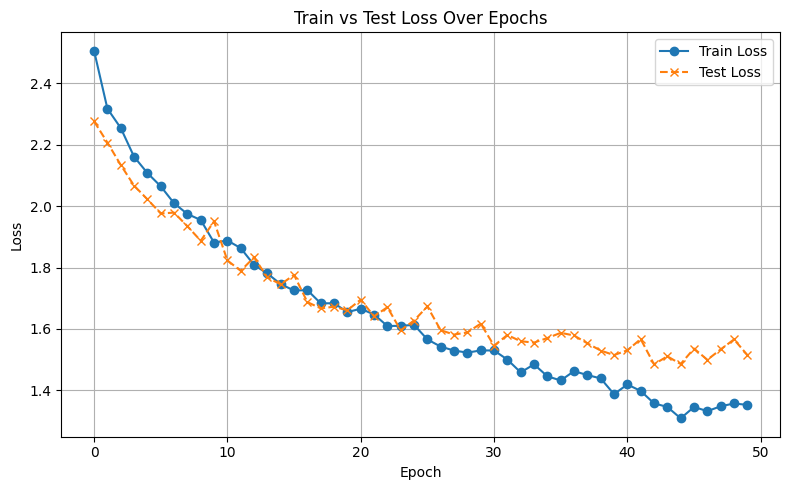

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(test_losses, label='Test Loss', marker='x', linestyle='--')
plt.title("Train vs Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [189]:
# Convert lists to numpy arrays for sklearn functions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
num_classes=24

precision_macro = precision_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))
recall_macro = recall_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))
f1_macro = f1_score(all_labels, all_preds, average='macro', labels=np.arange(num_classes))

precision_weighted = precision_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))
recall_weighted = recall_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))
f1_weighted = f1_score(all_labels, all_preds, average='weighted', labels=np.arange(num_classes))

accuracy = accuracy_score(all_labels, all_preds)

# Print all metrics
print(f"Macro Average Precision: {precision_macro:.4f}")
print(f"Macro Average Recall: {recall_macro:.4f}")
print(f"Macro Average F1 Score: {f1_macro:.4f}")

print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

print(f"Accuracy: {accuracy:.4f}")

Macro Average Precision: 0.3805
Macro Average Recall: 0.2810
Macro Average F1 Score: 0.3018
Weighted Average Precision: 0.5246
Weighted Average Recall: 0.5408
Weighted Average F1 Score: 0.5031
Accuracy: 0.5408


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

In [190]:
# Save the model (after training)
torch.save(model.state_dict(), "best_lstm_model_hazard.pth")
